In [11]:
import os
import argparse
import time
import glob
import pickle
import subprocess
import shlex
import io
import pprint
import importlib
from urllib.request import urlopen
from IPython.display import Image as dispImg
import scipy.io
import numpy as np
import pandas
import tqdm
import fire
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.model_zoo
import torchvision
from art.classifiers import PyTorchClassifier
import cornet
from art.attacks import BoundaryAttack
from art.attacks import HopSkipJump
from imgaug import augmenters as iaa
import imgaug as ia
#attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=0, max_eval=1000, init_eval=10)
from art.attacks import FastGradientMethod
from art.attacks import ProjectedGradientDescent

from PIL import Image
Image.warnings.simplefilter('ignore')

ia.seed(1)
np.random.seed(0)
torch.manual_seed(0)



mean = torch.tensor([0.44, 0.44, 0.44], dtype=torch.float32)
std = torch.tensor([0.225, 0.225, 0.225], dtype=torch.float32)
normalize = torchvision.transforms.Normalize(mean=[0.44, 0.44, 0.44],
                                             std=[0.225, 0.225, 0.225])
transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize(256),
                torchvision.transforms.CenterCrop(224),
                torchvision.transforms.ToTensor(),
                normalize
            ])
unnormalize = torchvision.transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def get_model(model_size='z', cuda=False):
    map_location = 'cpu' if not cuda else None
    #map_location = None
    model = getattr(cornet, f'cornet_{model_size.lower()}')
    if model_size.lower() == 'r':
        model = model(pretrained=True, map_location=map_location, times=5)
    else:
        model = model(pretrained=True, map_location=map_location)
    if cuda:
        model = model.cuda()
        return model
    model.cpu()
    return model.module

sharpen = iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5), deterministic=True)


                # Same as sharpen, but for an embossing effect.
emboss = iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0), deterministic=True)


Load data

In [12]:
labels = pickle.load(open("labels.pkl", "rb" ))
y_val = np.load("D:\\imagenet2012\\y_val.npy")
print(f"{y_val.shape[0]} validation labels loaded")
data_path = 'D:\\imagenet2012\\val'
fnames = sorted(glob.glob(os.path.join(data_path, '*.*')))
print(f"{len(fnames)} files found");

50000 validation labels loaded
50000 files found


In [13]:
def to_grayscale(img):
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])

In [14]:
def get_image_by_class(image_class):
    return Image.open(fnames[np.argsort((y_val == image_class))[-1]]).convert('RGB')

In [15]:
def plot_augmented(original_image, adv_image):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
    axes[0, 0].imshow(to_grayscale(original_image))
    axes[0, 1].imshow(to_grayscale(adv_image))
    axes[1, 0].imshow(to_grayscale(sharpen.augment_image(original_image)))
    axes[1, 1].imshow(to_grayscale(sharpen.augment_image(adv_image)))
    axes[2, 0].imshow(to_grayscale(emboss.augment_image(original_image)))
    axes[2, 1].imshow(to_grayscale(emboss.augment_image(adv_image)))
    plt.show()

In [16]:
def perform_attack(im, model_size, target_class=None, targeted=False, show_info=True, params={'max_iter': 100}):
    model = get_model(model_size)
    model.eval()
    if show_info:
        print(f'using model type: {model_size}')
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


    classifier = PyTorchClassifier(model=model, loss=criterion,
                               optimizer=optimizer, nb_classes=1000, input_shape=(3,224,224), clip_values=(-1.956, 6.4))
    #attack = ProjectedGradientDescent(classifier=classifier, targeted=targeted, **params)
    attack = FastGradientMethod(classifier=classifier, eps=0.3, targeted=targeted, minimal=True)
    x = transform(im).unsqueeze(0).numpy()
    
    pred = classifier.predict(x)[0]
    pred = np.exp(pred)/sum(np.exp(pred))
    if show_info:
        top_5 = np.flip(np.argsort(pred)[-5:])
        print('\nOriginal image predictions:')
        for t in top_5:
            print(f'{labels[t]} ({t}): {pred[t]}')
        print('\nGenerating adversarial example')
    
    x_adv = attack.generate(x=transform(im).unsqueeze(0).numpy(), y=np.array([target_class]) if target_class is not None else None)
    if show_info:
        print('L2: ' + str(np.linalg.norm(np.reshape(x_adv[0] - x[0], [-1]))))
    
    original_image = np.moveaxis(unnormalize(torch.from_numpy(x[0])).numpy(),  [0, 1, 2], [2, 0, 1])
    adv_image = np.moveaxis(unnormalize(torch.from_numpy(x_adv[0])).numpy(),  [0, 1, 2], [2, 0, 1])
    pert = np.abs(adv_image - original_image)[..., ::-1]
    pert_min = np.min(pert)
    pert_max = np.max(pert)
    pert_image = -((pert - pert_min) / (pert_max - pert_min))+1

    
    adv_pred = classifier.predict(x_adv)[0]
    adv_pred = np.exp(adv_pred)/sum(np.exp(adv_pred))
    if show_info:
        top_5 = np.flip(np.argsort(adv_pred)[-5:])
        print('\nAdversarial image predictions:')
        for t in top_5:
            print(f'{labels[t]} ({t}): {adv_pred[t]}')
    
    plt.show()
    return adv_pred

In [17]:
def get_classifier(model_size='z'):
    model = get_model(model_size)
    model.eval()
    print(f'using model type: {model_size}')

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


    classifier = PyTorchClassifier(model=model, loss=criterion,
                                   optimizer=optimizer, nb_classes=1000, input_shape=(3,224,224), clip_values=(-1.956, 6.4))
    return classifier

In [18]:
z = get_classifier()
s = get_classifier('s')
    


using model type: z
using model type: s


In [19]:
def predict(classifier, photo, show_pic=True):
    im = Image.open(f"C:\\Users\\serge\\Pictures\\106_PANA\\{photo}.jpg").convert('RGB')

    x = transform(im).unsqueeze(0).numpy()

    pred = classifier.predict(x)[0]
    pred = np.exp(pred)/sum(np.exp(pred))
    top_5 = np.flip(np.argsort(pred)[-5:])
    print('\nOriginal image predictions:')
    for t in top_5:
        print(f'{labels[t]} ({t}): {pred[t]}')
    if show_pic:
        plt.imshow(np.moveaxis(unnormalize(torch.from_numpy(x[0])).numpy(),  [0, 1, 2], [2, 0, 1]))
        plt.show()

In [20]:
def get_features(data, model_size='s', time_step=0):
    def _store_feats(layer, inp, output):
        """An ugly but effective way of accessing intermediate model features
        """
        _model_feats.append(np.reshape(output, (len(output), -1)).numpy())

    model = get_model(model_size=model_size)
    model.eval()
    model_layer = getattr(getattr(model, 'decoder'), 'flatten')
    model_layer.register_forward_hook(_store_feats)

    model_feats = []
    with torch.no_grad():
        for im in tqdm.tqdm(data):
            _model_feats = []
            model(im.unsqueeze(0))
            model_feats.append(_model_feats[time_step])
        model_feats = np.concatenate(model_feats)
    return model_feats

In [21]:
songbird_classes = [10, 15, 19, 14]
waterbird_classes = [99,100,137,144]
birds_of_prey_classes = [21,22,23,24]
dog_classes = [151,152,153,163]
cat_classes = [281,283,284,285]

images = []
image_labels = []

sz = 50

colors = ['g'] * sz + ['b'] * sz + ['r'] * sz + ['black'] * sz + ['yellow'] * sz

for cls in [songbird_classes, waterbird_classes, birds_of_prey_classes, dog_classes, cat_classes]:
    for im_index in np.random.choice(np.argwhere(np.isin(y_val, cls)).flatten(), sz, replace=False):
        im = Image.open(fnames[im_index]).convert('RGB')
        images.append(im)
        image_labels.append(y_val[im_index])



In [85]:
X = []
for image in images:
    X.append(transform(image).numpy())
X = np.array(X)
X = torch.from_numpy(X)

In [86]:
f_s = get_features(X, 's')

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [02:35<00:00,  1.69it/s]


In [87]:
f_z = get_features(X, 'z')

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:17<00:00, 14.66it/s]


In [88]:
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)


In [89]:
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
tsne_fs = tsne.fit_transform(f_s)

Computing t-SNE embedding


In [90]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
tsne_fz = tsne.fit_transform(f_z)

<IPython.core.display.Javascript object>


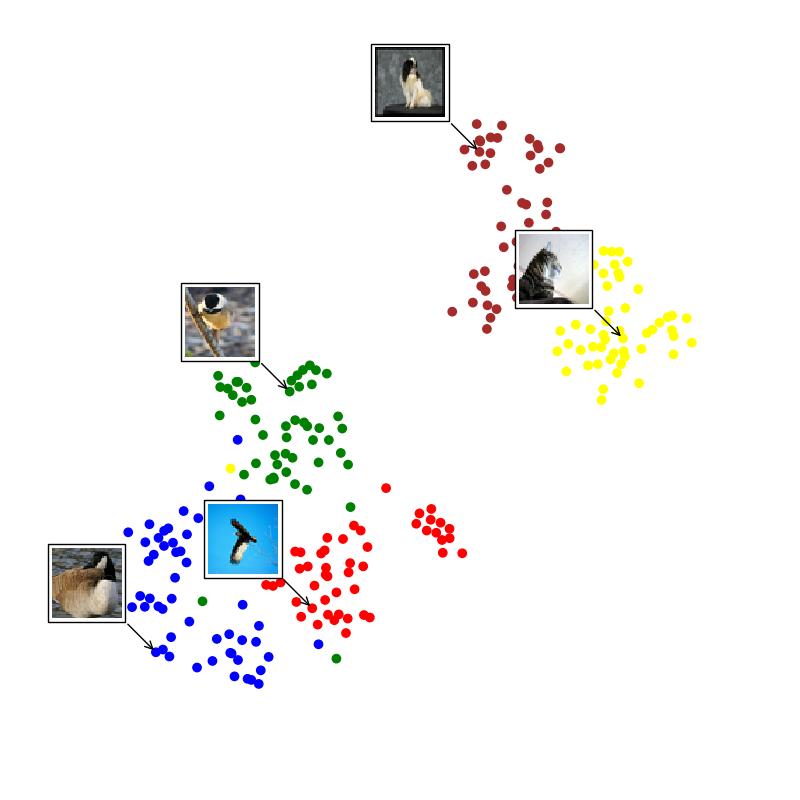

In [123]:
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
ax.scatter(tsne_fs[:, 0], tsne_fs[:, 1], c=colors)

for i in [6,110, 90, 161, 200]:
    ab = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i].resize((50, 50), Image.ANTIALIAS)), 
                                  [tsne_fs[i, 0], tsne_fs[i, 1]], xybox=(-50., 50.),
                            xycoords='data', boxcoords="offset points",
                            pad=0.3, arrowprops=dict(arrowstyle="->"))
    ax.add_artist(ab)

ax.axis('off')
plt.savefig('tnse_s.png')
plt.show()

<IPython.core.display.Javascript object>


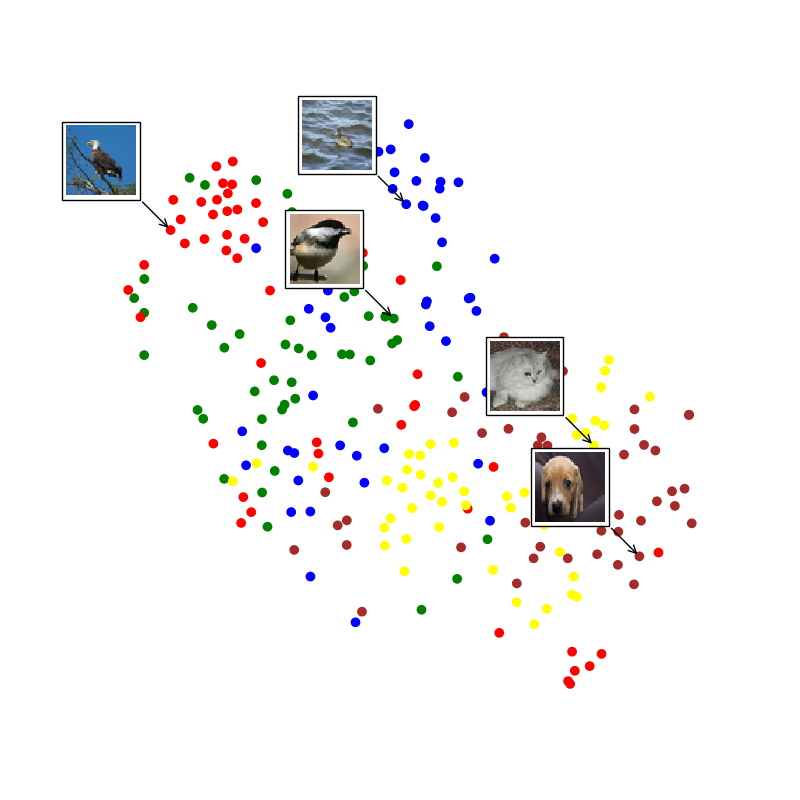

In [124]:
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
ax.scatter(tsne_fz[:, 0], tsne_fz[:, 1], c=colors)

for i in [17, 111, 72, 175, 222]:
    ab = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i].resize((50, 50), Image.ANTIALIAS)), [tsne_fz[i, 0], tsne_fz[i, 1]], xybox=(-50., 50.),
                            xycoords='data', boxcoords="offset points",
                            pad=0.3, arrowprops=dict(arrowstyle="->"))
    ax.add_artist(ab)
ax.axis('off')
plt.savefig('tsne_z.png')
plt.show()

<IPython.core.display.Javascript object>


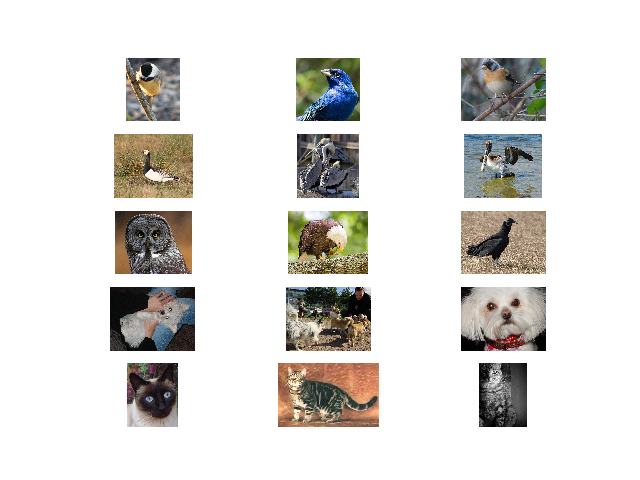

In [131]:
fig, axes = plt.subplots(nrows=5, ncols=3)
for i in range(5):
    for j in range(3):
        axes[i, j].imshow(images[i*50+6+j])
        axes[i, j].axis('off')
plt.savefig('animals.png')
plt.show()


In [9]:
np.delete([1,2,3], 2)

array([1, 2])

In [23]:
matrix = np.zeros((5,5))
cls = [songbird_classes, waterbird_classes, birds_of_prey_classes, dog_classes, cat_classes]
n = 0
for i in range(5):
    for j in range(5):
        for im_index in np.random.choice(np.argwhere(np.isin(y_val, cls[i])).flatten(), 100, replace=False):
            im = Image.open(fnames[im_index]).convert('RGB')
            target = np.random.choice(np.setdiff1d(cls[j],[y_val[im_index]]), 1)[0]
            adv_s = perform_attack(im, 's', target, True, show_info=False)
    
            if target == np.argmax(adv_s):
                matrix[i, j] += 1


print(matrix)

[[29.  5. 15.  1.  2.]
 [ 1. 47. 22.  3.  7.]
 [ 4. 12. 52.  1. 10.]
 [ 1.  2.  2. 12. 22.]
 [ 3.  3.  2. 12. 57.]]


In [179]:
np.random.choice(cls[0], 1)[0]

10

In [163]:

cls = [songbird_classes, waterbird_classes, birds_of_prey_classes, dog_classes, cat_classes]





# for i in range(5):
#     im = images[50+i]
#     target = np.random.choice(cls[0], 1)[0]
#     adv_s = perform_attack(im, 's', target, True, show_info=True)
    
#     adv_class_s = np.argmax(adv_s)
#     if target == adv_class_s and adv_s[adv_class_s] >= 0.5:
#         song += 1

# print(song)
raptor = 0

for i in range(50):
    im = images[50+i]
    target = np.random.choice(cls[2], 1)[0]
    adv_s = perform_attack(im, 's', target, True, show_info=False)
    
    adv_class_s = np.argmax(adv_s)
    if target == adv_class_s and adv_s[adv_class_s] >= 0.5:
        raptor += 1
print(raptor)

# for i in range(30):
#     im = images[50+i]
#     target = np.random.choice(cls[3], 1)[0]
#     adv_s = perform_attack(im, 's', target, True, show_info=False)
    
#     adv_class_s = np.argmax(adv_s)
#     if target == adv_class_s and adv_s[adv_class_s] >= 0.5:
#         dog += 1

#print(dog)

39


In [164]:
dog = 0
for i in range(50):
    im = images[50+i]
    target = np.random.choice(cls[3], 1)[0]
    adv_s = perform_attack(im, 's', target, True, show_info=False)
    
    adv_class_s = np.argmax(adv_s)
    if target == adv_class_s and adv_s[adv_class_s] >= 0.5:
        dog += 1

print(dog)

40


In [183]:
song = 0
for i in range(10):
    im = images[60+i]
    target = np.random.choice(cls[0], 1)[0]
    adv_s = perform_attack(im, 's', target, True, show_info=True)
    
    adv_class_s = np.argmax(adv_s)
    if target == adv_class_s:
        song += 1

print(song)

using model type: s

Original image predictions:
American coot, marsh hen, mud hen, water hen, Fulica americana (137): 0.9997319579124451
European gallinule, Porphyrio porphyrio (136): 0.00020678763394244015
drake (97): 1.9865541617036797e-05
goose (99): 1.7459233276895247e-05
black swan, Cygnus atratus (100): 1.61400548677193e-05

Generating adversarial example
L2: 116.39304

Adversarial image predictions:
American coot, marsh hen, mud hen, water hen, Fulica americana (137): 0.2608516812324524
ruffed grouse, partridge, Bonasa umbellus (82): 0.049828898161649704
quail (85): 0.04247167706489563
partridge (86): 0.04194401577115059
junco, snowbird (13): 0.04098768159747124
using model type: s

Original image predictions:
pelican (144): 0.9798421263694763
spoonbill (129): 0.00834597833454609
limpkin, Aramus pictus (135): 0.003517796751111746
American egret, great white heron, Egretta albus (132): 0.0031531311105936766
crane (134): 0.002447510603815317

Generating adversarial example
L2: 11

In [166]:
cat = 0
for i in range(50):
    im = images[50+i]
    target = np.random.choice(cls[4], 1)[0]
    adv_s = perform_attack(im, 's', target, True, show_info=False)
    
    adv_class_s = np.argmax(adv_s)
    if target == adv_class_s and adv_s[adv_class_s] >= 0.5:
        cat += 1

print(cat)

39


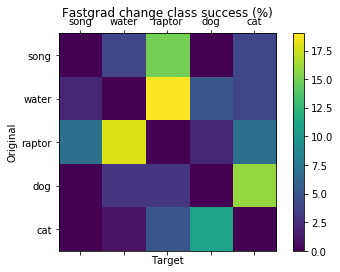

In [25]:
from sklearn.metrics import confusion_matrix

labels = ['song', 'water', 'raptor', 'dog', 'cat']
matrix = [[ 0,  4, 15,  0,  4],
 [ 2,  0, 19,  5,  4],
 [ 7, 18,  0,  2,  7],
 [ 0,  3,  3,  0, 16],
 [ 0,  1,  5, 11,  0]]

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix)
plt.title('Fastgrad change class success (%)')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Target')
plt.ylabel('Original')
plt.savefig('fastgradatk_nodiag.png')
plt.show()